In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
from scipy import stats
import statsmodels.api as sm
from matplotlib import pyplot as plt

<b>Avocado Prices</b><br>
https://www.kaggle.com/neuromusic/avocado-prices

Предположим, что мы решили открыть сеть магазинов здорового питания. <br>
Одним из товаров в нашем ассортименте будет авокадо. Необходимо на основании цен прошлых лет предсказать цену на авокадо на следующий год.

In [2]:
df = pd.read_csv('./avocado/avocado.csv')

In [3]:
df.head(5)

,Unnamed: 0,Date,AveragePrice,Total Volume,4046,4225,4770,Total Bags,Small Bags,Large Bags,XLarge Bags,type,year,region
0,0,2015-12-27,1.33,64236.62,1036.74,54454.85,48.16,8696.87,8603.62,93.25,0.0,conventional,2015,Albany
1,1,2015-12-20,1.35,54876.98,674.28,44638.81,58.33,9505.56,9408.07,97.49,0.0,conventional,2015,Albany
2,2,2015-12-13,0.93,118220.22,794.70,109149.67,130.50,8145.35,8042.21,103.14,0.0,conventional,2015,Albany
3,3,2015-12-06,1.08,78992.15,1132.00,71976.41,72.58,5811.16,5677.40,133.76,0.0,conventional,2015,Albany
4,4,2015-11-29,1.28,51039.60,941.48,43838.39,75.78,6183.95,5986.26,197.69,0.0,conventional,2015,Albany


### Из описания к датасету:

<li>Date - The date of the observation
<li>AveragePrice - the average price of a single avocado
<li>type - conventional or organic
<li>year - the year
<li>Region - the city or region of the observation
<li>Total Volume - Total number of avocados sold
<li>4046 - Total number of avocados with PLU 4046 sold
<li>4225 - Total number of avocados with PLU 4225 sold
<li>4770 - Total number of avocados with PLU 4770 sold

PLU - специальная маркировка, позволяющая определить овощи/фрукты/зелень, в тч генетически модифицированную продукцию

Будем предсказывать AveragePrice

### Распределения цены

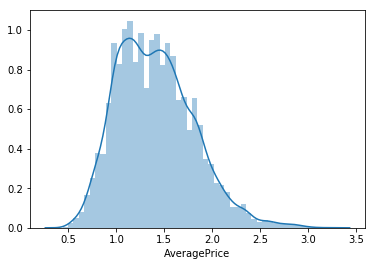

In [4]:
sns.distplot(df['AveragePrice'])

Легко заметить два кластера: у одного цена в районе 1.5, у другого +-1.0

In [5]:
df.head(5)

,Unnamed: 0,Date,AveragePrice,Total Volume,4046,4225,4770,Total Bags,Small Bags,Large Bags,XLarge Bags,type,year,region
0,0,2015-12-27,1.33,64236.62,1036.74,54454.85,48.16,8696.87,8603.62,93.25,0.0,conventional,2015,Albany
1,1,2015-12-20,1.35,54876.98,674.28,44638.81,58.33,9505.56,9408.07,97.49,0.0,conventional,2015,Albany
2,2,2015-12-13,0.93,118220.22,794.70,109149.67,130.50,8145.35,8042.21,103.14,0.0,conventional,2015,Albany
3,3,2015-12-06,1.08,78992.15,1132.00,71976.41,72.58,5811.16,5677.40,133.76,0.0,conventional,2015,Albany
4,4,2015-11-29,1.28,51039.60,941.48,43838.39,75.78,6183.95,5986.26,197.69,0.0,conventional,2015,Albany


Взглянем на зависимости между признаками

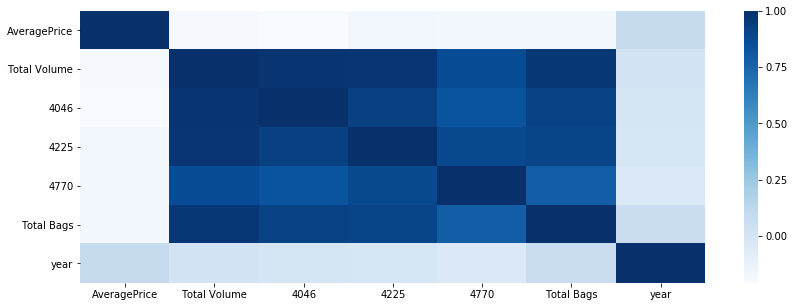

In [6]:
cols = ['AveragePrice', 'Total Volume', '4046', '4225', '4770', 'Total Bags', 'year', 'region', 'type']
fig = plt.figure(figsize= (14,5))
sns.heatmap(df[cols].corr(), cmap = 'Blues')

Видно, что целевой признак зависит только от года

Так как мы предсказываем цену, то логично убрать некоторые лишние данные

In [7]:
df = df.drop(['Total Bags', 'Small Bags', 
              'Large Bags', 'XLarge Bags', 
              '4046', '4225', 
              '4770',
              'Total Volume', 'Unnamed: 0'], axis=1)

In [8]:
df.head()

,Date,AveragePrice,type,year,region
0,2015-12-27,1.33,conventional,2015,Albany
1,2015-12-20,1.35,conventional,2015,Albany
2,2015-12-13,0.93,conventional,2015,Albany
3,2015-12-06,1.08,conventional,2015,Albany
4,2015-11-29,1.28,conventional,2015,Albany


Два кластера - два типа продуктов (type:'conventional'|'organic') - <b>Органические</b> и <b>неорганические</b> <br>
Взглянем на их распределения

In [9]:
organic = df[df['type'] == 'organic']
conventional = df[df['type'] == 'conventional']

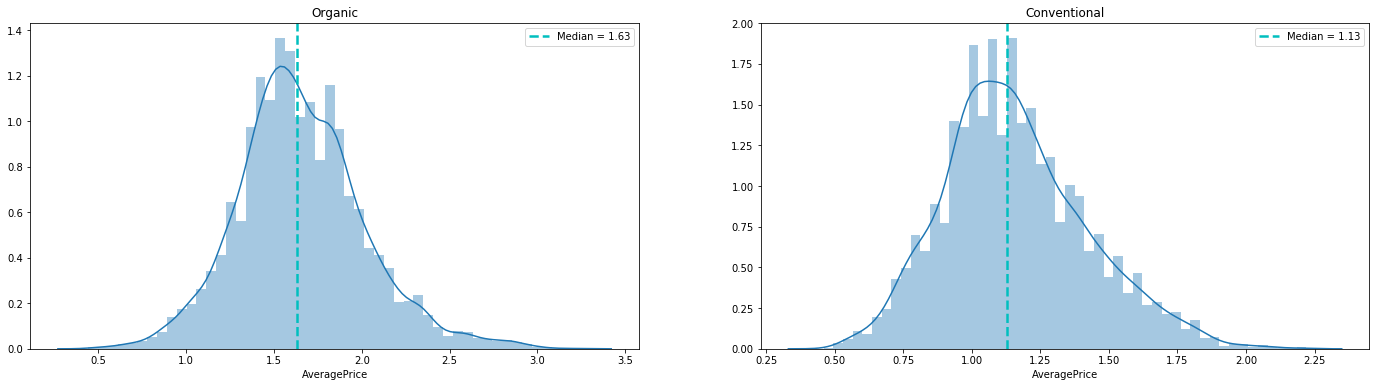

In [10]:
fig = plt.figure(figsize=(24, 6))
ax1 = plt.subplot(121)
ax2 = plt.subplot(122)

org = sns.distplot(organic['AveragePrice'], ax=ax1)
line1 = org.axvline(np.median(organic['AveragePrice']), 
                    color='c', linestyle='dashed', 
                    label=('Median = '+str(round(np.median(organic['AveragePrice']), 2))), 
                    linewidth=2.5)
org.set_title('Organic')
org.legend(handles=[line1])

conv = sns.distplot(conventional['AveragePrice'], ax=ax2)
line2 = conv.axvline(np.median(conventional['AveragePrice']), 
                    color='c', linestyle='dashed', 
                    label=('Median = '+str(round(np.median(conventional['AveragePrice']), 2))), 
                    linewidth=2.5)
conv.set_title('Conventional')
conv.legend(handles=[line2])

<b> Действительно</b>, цена на органическую продукцию несколько выше, чем на неорганическую 

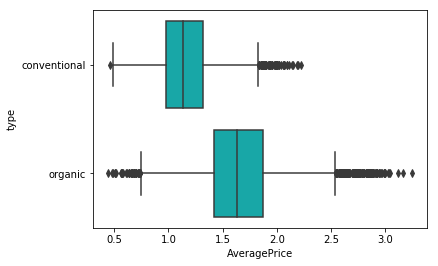

In [11]:
sns.boxplot(y="type", x="AveragePrice", data=df, color='c')

Проверим аналитически, что каждый тип принадлежит к разным распределениям

Почти никогда выборка не бывает распределена нормально, как правило, даже если она и имеет форму колокола, то у нее более тяжелые хвосты и критерий Стьюдента на таких наблюдениях уже плохо работает<br>
Ради большей формальности проверим выборки на нормальность

In [12]:
print('Organics dist', 
      'is normal' if stats.shapiro(organic['AveragePrice'][:5000])[1] > 0.05 else 'isnt normal',
     '\nConventional dist',
      'is normal' if stats.shapiro(conventional['AveragePrice'][:5000])[1] > 0.05 else 'isnt normal'
     )

Organics dist isnt normal 
Conventional dist isnt normal


Проверим при помощи критерия Манна-Уитни гипотезу однородности против альтернативы доминирования и заметим, что наше предположение подтвердилось, цена на органическую продукцию выше

In [13]:
stats.mannwhitneyu(organic['AveragePrice'], conventional['AveragePrice'], alternative='greater')

MannwhitneyuResult(statistic=72573720.0, pvalue=0.0)

In [14]:
stats.mannwhitneyu(organic['AveragePrice'], conventional['AveragePrice'], alternative='less')

MannwhitneyuResult(statistic=72573720.0, pvalue=1.0)

Имеет смысл предсказывать цену в зависимости от типа продукта

### Зависимость цены от региона

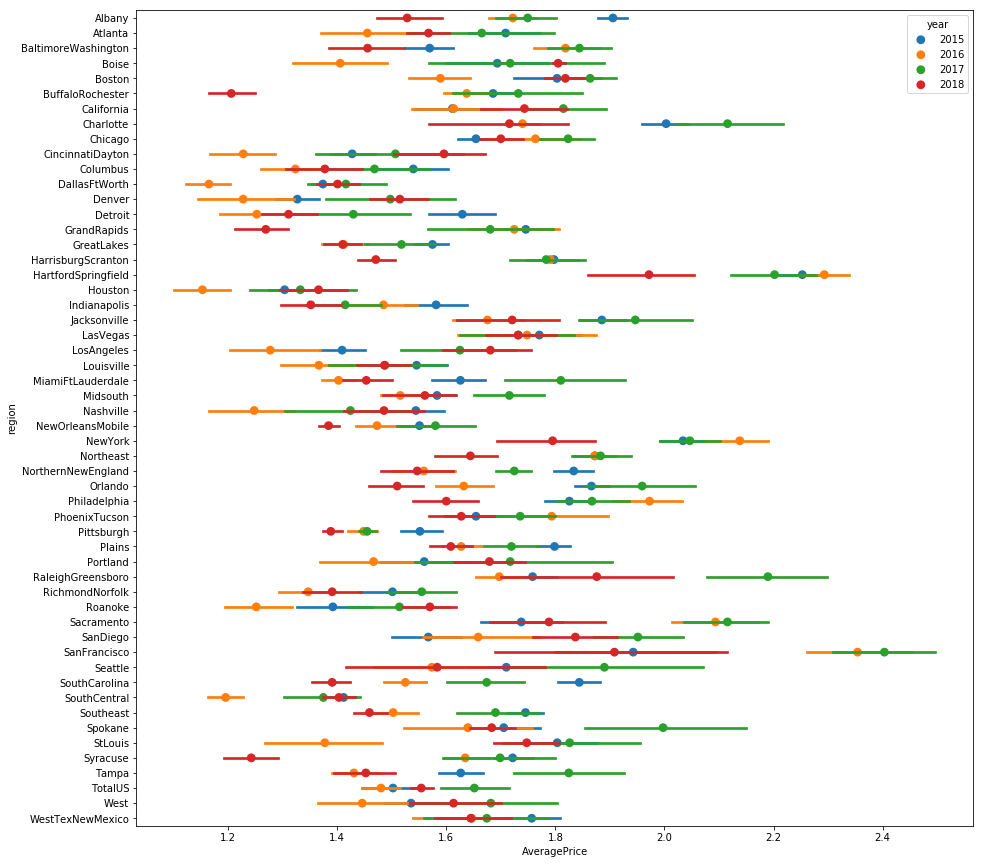

In [15]:
fig = plt.figure(figsize=(15, 15))
sns.pointplot(x='AveragePrice', y='region', hue='year', data=organic, join=False)

В SanFrancisco рынок наиболее волатилен, возможно, следует спекулировать именно там ради обеспечения большего дохода, однако, это ведет за собой большие риски

Данный график явно отражает, что зависимость целевого признака от времени есть, причем для каждого региона разная

Можно было бы предсказывать цену для какого-то отдельного города, но мы будем предсказывать общерыночную

In [16]:
organic = organic.drop(['type', 'region'], axis=1)

In [17]:
organic = organic.groupby('Date', as_index=False).mean()

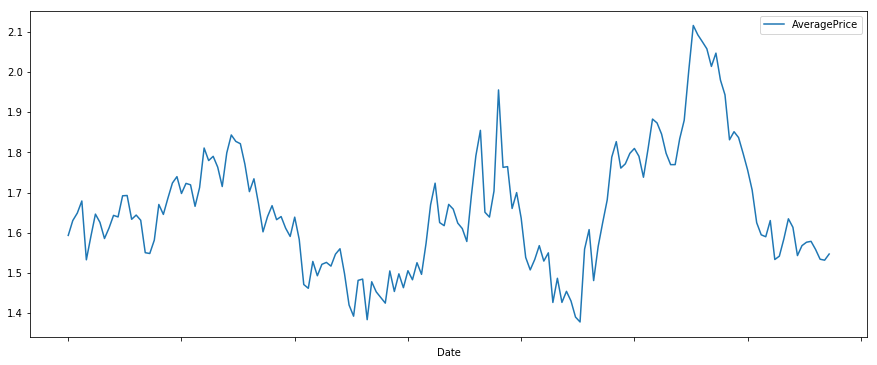

In [18]:
organic.plot(x='Date', y='AveragePrice', figsize=(15,6))

In [19]:
test_ = sm.tsa.adfuller(organic['AveragePrice'])
print ('adf: ', test_[0] )
print ('p-value: ', test_[1])
print('Critical values: ', test_[4])
if test_[0]> test_[4]['5%']: 
    print ('есть единичные корни, ряд не стационарен')
else:
    print ('единичных корней нет, ряд стационарен')

adf:  -3.26764152011
p-value:  0.0163883305301
Critical values:  {'1%': -3.4727031195048541, '5%': -2.8801316723537318, '10%': -2.5766826861130268}
единичных корней нет, ряд стационарен


Так как ряд стационарен, у него нет выраженного тренда, отсутствует сезонность, то имеет смысл применить экспоненциальное сглаживание

In [20]:
from statsmodels.tsa.api import ExponentialSmoothing

In [21]:
train = organic[:-11]
test = organic[-12:]
y_hat = test.copy()

([], <a list of 0 Text xticklabel objects>)

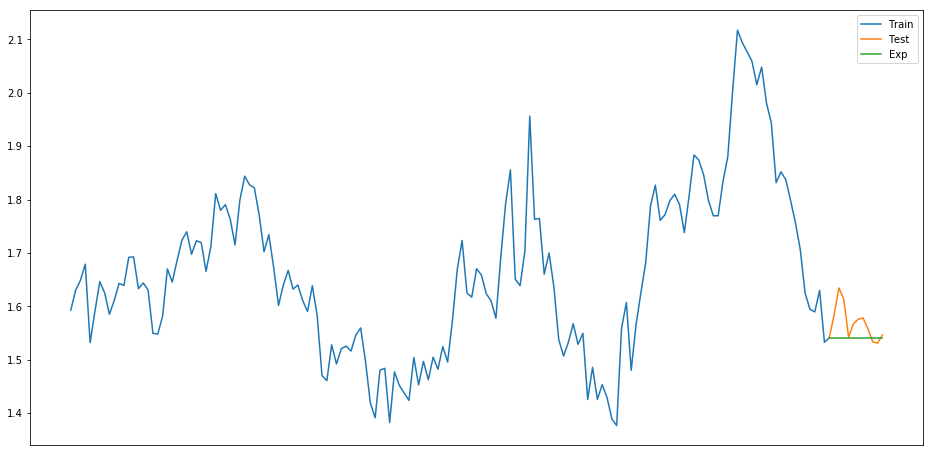

In [22]:
fit = ExponentialSmoothing(np.asarray(train.AveragePrice)).fit()
y_hat['AveragePrice'] = fit.forecast(len(test))

fig = plt.figure(figsize=(16,8))
plt.plot(train['AveragePrice'], label='Train')
plt.plot(test['AveragePrice'], label='Test')
plt.plot(y_hat['AveragePrice'], label='Exp')
plt.legend()
plt.xticks([])

Так как сеть магазинов у нас только открылась, то пессимистичное предсказание имеет несколько большую ценность